# Create genomic windows

In [1]:
import pybedtools

In [2]:
hg38_chrom_sizes_file = "../data/genome_file/GRCh38.chrom.sizes.simple.sorted"
hg38_genome_bed = pybedtools.BedTool().window_maker(g=hg38_chrom_sizes_file, w=500)
hg38_genome_bed.moveto("../data/genome_file/GRCh38_window.bed")

<BedTool(../data/genome_file/GRCh38_window.bed)>

# Convert bigwig files to bed files

Example scripts to convert bigwig files to bed files for Johnson et. al. data

```bash
multiBigwigSummary BED-file -b ./GSM31318*_0hr_*.bw -o ./output.npz --BED ../genome_file/GRCh38_window.bed -p 4 --outRawCounts ./output0_rawcounts.tsv
```

```bash
multiBigwigSummary BED-file -b ./GSM31318*_input_dna*.bw -o ./input.npz --BED ../genome_file/GRCh38_window.bed -p 4 --outRawCounts ./input_rawcounts.tsv
```


# Compare same fragments activity from different studies

In [9]:
import os
import numpy as np
import pandas as pd
import itertools as it
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})

In [4]:
def parse_raw_counts(file):
    df = pd.read_csv(file, sep="\t")
    df.columns = [c.strip("#").strip("'") for c in df.columns]
    df = df.set_index(["chr", "start", "end"]).fillna(0).mean(axis=1)
    return df.sort_index()


def normalize_df(df):
    # make every fractional signal zero
    df.loc[df<1] = 0
    # # normalize signal
    df = (df - df.min())/(df.max() - df.min())
    # adding a pseudocount
    df += 1
    return df


def get_fold_change_values(inrawcounts_file, outrawcounts_file):
    in_df = parse_raw_counts(inrawcounts_file)
    out_df = parse_raw_counts(outrawcounts_file)
    # input normalized to take care of high and low mappability
    in_df = normalize_df(in_df)
    # out_df = normalize_df(out_df)
    assert (in_df.index == out_df.index).all()
    fc_df = out_df.div(in_df)
    # fc_df.loc[~np.isfinite(fc_df)] = np.nan
    return fc_df #.fillna(0)

In [5]:
jr_0_fc_df = get_fold_change_values(
    "../data/johnson/processed/input_rawcounts.tsv",
    "../data/johnson/processed/output0_rawcounts.tsv"
)

lg_hepg2_fc_df = parse_raw_counts("../data/lee/hepg2_fc_rawcounts.tsv")


lg_k562_fc_df = parse_raw_counts("../data/lee/k562_fc_rawcounts.tsv")

In [6]:
fc_df = pd.concat((jr_0_fc_df, lg_hepg2_fc_df, lg_k562_fc_df), axis=1)
fc_df.columns = ["jr_0", "lg_hepg2", "lg_k562"]
# fc_df.corr().to_csv("../data/wgs_corr_compare_pearson.csv")
# fc_df.corr(method="spearman").to_csv("../data/wgs_corr_compare_spearman.csv")



In [7]:
fc_df_transformed2 = pd.DataFrame(np.log2(fc_df.loc[(fc_df>0).all(axis=1)]), columns=fc_df.columns)


# Fig S7

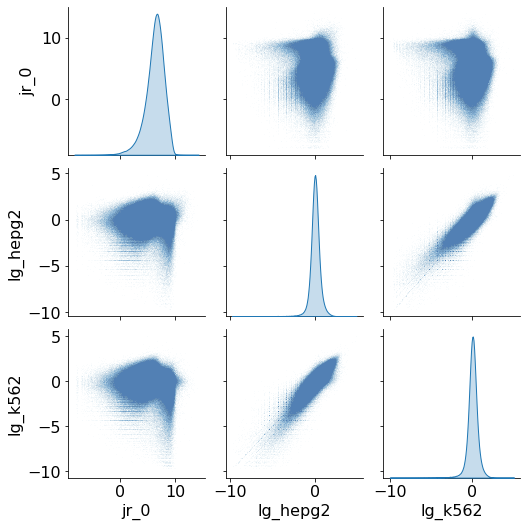

In [10]:
g = sns.pairplot(fc_df_transformed2, diag_kind="kde", plot_kws={"s": 0.5, 'alpha': 0.05})
for a in g.fig.axes:
    if len(a.collections)==1:
        a.collections[0].set_rasterized(True)